<a href="https://colab.research.google.com/github/Jennyc08/Telecomx_latam/blob/main/Final_TelecomX_LATAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [32]:
API_URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

In [33]:
# ==== CELDA 0: ARRANQUE SEGURO ====
import os, re, io, json, base64
from datetime import datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    sns = None

from pandas import json_normalize

URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
OUT_DIR = "reports"; os.makedirs(OUT_DIR, exist_ok=True)

def pick(colnames, *pats):
    low = {c.lower(): c for c in colnames}
    for p in pats:
        if isinstance(p, str) and p.lower() in low: return low[p.lower()]
        for k in low:
            if re.search(p, k, re.I): return low[k]
    return None

def churn_rate_from_series(s: pd.Series) -> float:
    s = s.dropna()
    if s.empty: return np.nan
    if s.isin([0,1]).all(): return float(s.mean())
    return float(s.astype("string").str.lower().isin(["yes","si","sí","1","true"]).mean())

def fig_to_base64(fig, close=True):
    buf = io.BytesIO(); fig.savefig(buf, format="png", bbox_inches="tight")
    if close: plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")

# Carga desde cero (evita estado viejo)
df_raw = pd.read_json(URL)
df = json_normalize(df_raw.to_dict(orient="records"), sep="__")

# Limpieza mínima imprescindible (para que lo demás no falle)
dfc = df.copy()
obj_cols = dfc.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    s = dfc[c].astype("string").str.strip()
    if s.nunique(dropna=True) <= max(100, 0.05*len(dfc)): s = s.str.lower()
    s = s.replace({"": pd.NA, "na": pd.NA, "n/a": pd.NA, "none": pd.NA, "null": pd.NA})
    dfc[c] = s

for c in dfc.columns:
    if dfc[c].dtype == "object":
        # fechas
        try:
            ts = pd.to_datetime(dfc[c], errors="coerce", infer_datetime_format=True)
            if ts.notna().mean() >= 0.3: dfc[c] = ts.dt.normalize()
        except: pass
        # numéricos
        try:
            num = pd.to_numeric(dfc[c].str.replace(",", ".", regex=False), errors="coerce")
            if num.notna().mean() >= 0.3: dfc[c] = num
        except: pass

# Target binario robusto
target = pick(dfc.columns, "churn", "evasion", r"(churn|evas)")
if target is None:
    raise ValueError("No encontré la columna objetivo (Churn/Evasión).")
y = dfc[target]
if not y.dropna().isin([0,1]).all():
    y = y.astype("string").str.lower().isin(["yes","si","sí","1","true"]).astype(int)

print("✅ Entorno listo. Filas:", len(dfc), "| target:", target)


✅ Entorno listo. Filas: 7267 | target: Churn


In [34]:
import requests
import pandas as pd

# URL raw del JSON
url = (
    "https://raw.githubusercontent.com/"
    "ingridcristh/challenge2-data-science-LATAM/"
    "main/TelecomX_Data.json"
)

# 1. Obtener los datos
response = requests.get(url, timeout=30)
response.raise_for_status()  # para fail rápido si algo va mal

# 2. Parsear JSON
data = response.json()  # espero que sea una lista de dicts o estructura similar

# 3. Convertir a DataFrame
df = pd.DataFrame(data)

# 4. Mostrar resumen
print("Dimensiones:", df.shape)
print(df.dtypes)
print(df.head())


Dimensiones: (7267, 6)
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'Intern

In [35]:
def load_data_from_github(raw_url: str) -> pd.DataFrame:
    resp = requests.get(raw_url, timeout=30)
    resp.raise_for_status()
    return pd.DataFrame(resp.json())

if __name__ == "__main__":
    url = (
        "https://raw.githubusercontent.com/"
        "ingridcristh/challenge2-data-science-LATAM/"
        "main/TelecomX_Data.json"
    )
    df = load_data_from_github(url)
    print(df.shape, df.columns.tolist())


(7267, 6) ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']


#🔧 Transformación

### Conociendo el Conjunto de datos ###

In [36]:
import pandas as pd

# Fuente
URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# 1.1 Cargar
df = pd.read_json(URL)

# 1.2 Explorar
print("Shape:", df.shape)
display(df.head(3))
df.info()

# 1.3 Resumen rápido (tolerante a listas/dicts)
summary = pd.DataFrame({
    "tipo": df.dtypes.astype(str),
    "nulos(%)": (df.isna().sum()/len(df)*100).round(2),
    "ejemplos": [df[c].dropna().astype(str).unique()[:3] for c in df.columns]
}).reset_index(names="columna")
display(summary)


Shape: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,columna,tipo,nulos(%),ejemplos
0,customerID,object,0.0,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ]"
1,Churn,object,0.0,"[No, Yes, ]"
2,customer,object,0.0,"[{'gender': 'Female', 'SeniorCitizen': 0, 'Par..."
3,phone,object,0.0,"[{'PhoneService': 'Yes', 'MultipleLines': 'No'..."
4,internet,object,0.0,"[{'InternetService': 'DSL', 'OnlineSecurity': ..."
5,account,object,0.0,"[{'Contract': 'One year', 'PaperlessBilling': ..."


###Comprobación de incoherencia en los datos###



In [37]:
import json
import re

def make_hashable(x):
    if isinstance(x, (list, dict, set)):
        return json.dumps(x, sort_keys=True)
    return x

# 2.1 Nulos
nulos_pct = (df.isna().sum()/len(df)*100).sort_values(ascending=False).round(2)
print("Top nulos (%):\n", nulos_pct.head(10))

# 2.2 Duplicados (robusto)
df_hash = df.applymap(make_hashable)
dup_mask = df_hash.duplicated(keep=False)
print("Filas duplicadas:", int(dup_mask.sum()))

# 2.3 Formatos sospechosos (detección)
candidatos_obj = df.select_dtypes(include="object").columns
sospechosas_fecha, sospechosas_num = [], []
for c in candidatos_obj:
    # fecha
    try:
        ts = pd.to_datetime(df[c], errors="coerce")
        if ts.notna().mean() >= 0.3: sospechosas_fecha.append(c)
    except: pass
    # numérico
    try:
        num = pd.to_numeric(df[c].str.replace(",", ".", regex=False), errors="coerce")
        if num.notna().mean() >= 0.3: sospechosas_num.append(c)
    except: pass

print("Posibles fechas:", sospechosas_fecha)
print("Posibles numéricos:", sospechosas_num)

# 2.4 Categorías (muestra)
for c in df.select_dtypes(include="object").columns[:5]:
    print(f"{c} →", pd.unique(df[c].astype('string').str.strip().str.lower())[:8])




Top nulos (%):
 customerID    0.0
Churn         0.0
customer      0.0
phone         0.0
internet      0.0
account       0.0
dtype: float64
Filas duplicadas: 0


/tmp/ipython-input-2535780020.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hash = df.applymap(make_hashable)
/tmp/ipython-input-2535780020.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[c], errors="coerce")


Posibles fechas: []
Posibles numéricos: []
customerID → <StringArray>
['0002-orfbo', '0003-mknfe', '0004-tlhlj', '0011-igkff', '0013-exchz',
 '0013-mhzwf', '0013-smeoe', '0014-bmaqu']
Length: 8, dtype: string
Churn → <StringArray>
['no', 'yes', '']
Length: 3, dtype: string
customer → <StringArray>
["{'gender': 'female', 'seniorcitizen': 0, 'partner': 'yes', 'dependents': 'yes', 'tenure': 9}",
     "{'gender': 'male', 'seniorcitizen': 0, 'partner': 'no', 'dependents': 'no', 'tenure': 9}",
     "{'gender': 'male', 'seniorcitizen': 0, 'partner': 'no', 'dependents': 'no', 'tenure': 4}",
   "{'gender': 'male', 'seniorcitizen': 1, 'partner': 'yes', 'dependents': 'no', 'tenure': 13}",
  "{'gender': 'female', 'seniorcitizen': 1, 'partner': 'yes', 'dependents': 'no', 'tenure': 3}",
  "{'gender': 'female', 'seniorcitizen': 0, 'partner': 'no', 'dependents': 'yes', 'tenure': 9}",
 "{'gender': 'female', 'seniorcitizen': 1, 'partner': 'yes', 'dependents': 'no', 'tenure': 71}",
   "{'gender': 'male',

/tmp/ipython-input-2535780020.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[c], errors="coerce")


###Manejo de inconsistencia###

In [38]:
import numpy as np

dfc = df.copy()

# 3.1 Strings: trim + lower en cardinalidad baja; vacíos→NaN
obj_cols = dfc.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    s = dfc[c].astype("string").str.strip()
    if s.nunique(dropna=True) <= max(100, 0.05*len(dfc)):
        s = s.str.lower()
    s = s.replace({"": pd.NA, "na": pd.NA, "n/a": pd.NA, "none": pd.NA, "null": pd.NA, "sin dato": pd.NA})
    dfc[c] = s

# 3.2 Sí/No → 1/0
yn = {"sí":1,"si":1,"yes":1,"y":1,"true":1,"t":1,"1":1,1:1,
      "no":0,"n":0,"false":0,"f":0,"0":0,0:0}
for c in obj_cols:
    vals = dfc[c].dropna().astype(str).str.lower().unique().tolist()
    if set(vals) <= set(yn.keys()):
        dfc[c] = dfc[c].astype(str).str.lower().map(yn).astype("Int8")

# 3.3 Fechas (parse + normalize)
for c in dfc.columns:
    if dfc[c].dtype == "object":
        try:
            ts = pd.to_datetime(dfc[c], errors="coerce", infer_datetime_format=True)
            if ts.notna().mean() >= 0.3: dfc[c] = ts.dt.normalize()
        except: pass

# 3.4 Numéricos (coerce + coma→punto)
for c in dfc.columns:
    if dfc[c].dtype == "object":
        try:
            num = pd.to_numeric(dfc[c].str.replace(",", ".", regex=False), errors="coerce")
            if num.notna().mean() >= 0.3: dfc[c] = num
        except: pass

# 3.5 Reglas básicas (si existen estas columnas)
def pick(cols, *names_or_regex):
    low = {c.lower(): c for c in cols}
    for p in names_or_regex:
        if p.lower() in low: return low[p.lower()]
        for k in low:
            if re.search(p, k): return low[k]
    return None

col_monthly = pick(dfc.columns, "MonthlyCharges", r"monthly.*charge")
col_total   = pick(dfc.columns, "TotalCharges",   r"total.*charge")
col_tenure  = pick(dfc.columns, "tenure")
if col_monthly: dfc.loc[pd.to_numeric(dfc[col_monthly], errors="coerce") < 0, col_monthly] = np.nan
if col_total:   dfc.loc[pd.to_numeric(dfc[col_total],   errors="coerce") < 0, col_total]   = np.nan
if col_tenure:  dfc.loc[pd.to_numeric(dfc[col_tenure],  errors="coerce") < 0, col_tenure]  = np.nan

# 3.6 Imputación simple
for c in dfc.select_dtypes(include=[np.number]).columns:
    if dfc[c].isna().any(): dfc[c] = dfc[c].fillna(dfc[c].median())
for c in dfc.select_dtypes(include=["object","string","category"]).columns:
    if dfc[c].isna().any():
        moda = dfc[c].mode(dropna=True)
        if not moda.empty: dfc[c] = dfc[c].fillna(moda.iloc[0])

# 3.7 Duplicados (por id si existe; si no, por fila)
id_col = pick(dfc.columns, "customerID", r"customer.*id")
if id_col:
    dups = int(dfc.duplicated(subset=[id_col]).sum())
    dfc = dfc.drop_duplicates(subset=[id_col], keep="first")
else:
    dups = int(dfc.applymap(make_hashable).duplicated().sum())
    dfc = dfc.drop_duplicates(keep="first")
print("Duplicados removidos:", dups)

# 3.8 Outliers suaves (1–99%)
for c in dfc.select_dtypes(include=[np.number]).columns:
    q01, q99 = dfc[c].quantile([0.01, 0.99])
    dfc[c] = dfc[c].clip(lower=q01, upper=q99)

print("Shape tras limpieza:", dfc.shape)


Duplicados removidos: 0
Shape tras limpieza: (7267, 6)


###Columnas de Cuentas_Diarias###

In [39]:
import pandas as pd
import numpy as np
import re
from collections.abc import Mapping

# --- Funciones auxiliares ---
def deep_find(d, patt):
    """
    Busca recursivamente en dict/list cualquier clave cuyo nombre
    coincida con el patrón regex `patt`. Devuelve el primer valor encontrado.
    """
    rx = re.compile(patt, re.I)
    if isinstance(d, Mapping):
        for k, v in d.items():
            if rx.search(k):
                return v
            if isinstance(v, (Mapping, list)):
                found = deep_find(v, patt)
                if found is not None:
                    return found
    elif isinstance(d, list):
        for v in d:
            found = deep_find(v, patt)
            if found is not None:
                return found
    return None

# --- 1) Buscar cargos mensuales y días del ciclo ---
monthly_charges = []
billing_days = []

for _, row in dfc.iterrows():
    val_month = None
    val_days = None

    for col in ["account", "internet", "phone", "customer"]:
        if col in dfc.columns and isinstance(row[col], Mapping):
            if val_month is None:
                val_month = deep_find(row[col], r"(monthly|mensual).*?(charge|fee|amount)|cargos?_?mensuales")
            if val_days is None:
                val_days = deep_find(row[col], r"(days|d[ií]as).*?(cycle|billing|per[ií]odo)")

    monthly_charges.append(pd.to_numeric(val_month, errors="coerce"))
    billing_days.append(pd.to_numeric(val_days, errors="coerce"))

dfc["MonthlyCharges_found"] = monthly_charges
dfc["BillingDays_found"] = billing_days

# --- 2) Si no se encontró, derivar de TotalCharges / tenure ---
if "MonthlyCharges_found" in dfc:
    missing_month = dfc["MonthlyCharges_found"].isna()
    total_col  = next((c for c in dfc.columns if re.search(r"total.*charge|cargos.*totales", c, re.I)), None)
    tenure_col = next((c for c in dfc.columns if re.search(r"tenure|antig.*mes", c, re.I)), None)

    if total_col and tenure_col:
        total_num  = pd.to_numeric(dfc[total_col], errors="coerce")
        tenure_num = pd.to_numeric(dfc[tenure_col], errors="coerce").replace({0: np.nan})
        monthly_from_total = total_num / tenure_num
        dfc.loc[missing_month, "MonthlyCharges_found"] = monthly_from_total

# --- 3) Calcular Cuentas_Diarias ---
dias_final = dfc["BillingDays_found"].fillna(30).replace(0, 30)
dfc["Cuentas_Diarias"] = dfc["MonthlyCharges_found"] / dias_final
dfc.loc[dfc["Cuentas_Diarias"] < 0, "Cuentas_Diarias"] = np.nan

# --- 4) Ver resumen ---
print("Resumen Cuentas_Diarias:")
print(dfc["Cuentas_Diarias"].describe())
print("\nValores únicos más comunes:")
print(dfc["Cuentas_Diarias"].value_counts(dropna=False).head(10))


Resumen Cuentas_Diarias:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Cuentas_Diarias, dtype: float64

Valores únicos más comunes:
Cuentas_Diarias
NaN    7267
Name: count, dtype: int64


###Estandarización y transformación de los datos###

In [54]:
# --- Bloque seguro para renombrar columnas clave y crear df_std ---
import re, numpy as np, pandas as pd

def pick(colnames, *pats):
    low = {c.lower(): c for c in colnames}
    for p in pats:
        if isinstance(p, str) and p.lower() in low:
            return low[p.lower()]
        for k in low:
            if re.search(p, k, re.I):
                return low[k]
    return None

# 1) Detectar posibles columnas en dfc
monthly_col  = pick(dfc.columns, "cargos_mensuales", "MonthlyCharges", r"(monthly|mensual).*?(charge|fee|amount)")
col_total    = pick(dfc.columns, "cargos_totales", "TotalCharges", r"total.*charge")
col_tenure   = pick(dfc.columns, "antiguedad_meses", "tenure", r"\btenure\b")
billing_date = pick(dfc.columns, "fecha_facturacion", "BillingDate", "InvoiceDate", r"(bill|invoic).*date")
churn_col    = pick(dfc.columns, "evasion", "Churn", r"(churn|evas)")

# 2) Si NO hay cargo mensual, derivarlo de total/tenure
if monthly_col is None and col_total and col_tenure:
    total  = pd.to_numeric(dfc[col_total], errors="coerce")
    tenure = pd.to_numeric(dfc[col_tenure], errors="coerce").replace({0: np.nan})
    dfc["Monthly_from_total"] = total / tenure
    monthly_col = "Monthly_from_total"

# 3) Armar mapa de renombres (solo si existen)
rename_map = {}
if monthly_col:  rename_map[monthly_col]  = "cargos_mensuales"
if col_total:    rename_map[col_total]    = "cargos_totales"
if col_tenure:   rename_map[col_tenure]   = "antiguedad_meses"
if billing_date: rename_map[billing_date] = "fecha_facturacion"
if churn_col:    rename_map[churn_col]    = "evasion"

df_std = dfc.rename(columns=rename_map).copy()

print("Renombradas:", rename_map)
print("Columnas finales (preview):", df_std.columns[:20].tolist())

# 4) (Opcional) Crear Cuentas_Diarias si aún no existe
if "Cuentas_Diarias" not in df_std.columns and "cargos_mensuales" in df_std.columns:
    if "fecha_facturacion" in df_std.columns and pd.api.types.is_datetime64_any_dtype(df_std["fecha_facturacion"]):
        dias = df_std["fecha_facturacion"].dt.daysinmonth.replace(0, np.nan).fillna(30)
    else:
        dias = 30
    df_std["Cuentas_Diarias"] = pd.to_numeric(df_std["cargos_mensuales"], errors="coerce") / dias


Renombradas: {'MonthlyCharges_found': 'cargos_mensuales', 'Churn': 'evasion'}
Columnas finales (preview): ['customerID', 'evasion', 'customer', 'phone', 'internet', 'account', 'cargos_mensuales', 'BillingDays_found', 'Cuentas_Diarias', 'num_servicios']


In [55]:
# 5.1 Renombrar columnas clave (snake_case/es)
rename_map = {}
if monthly_col: rename_map[monthly_col] = "cargos_mensuales"
if col_total:   rename_map[col_total]   = "cargos_totales"
if col_tenure:  rename_map[col_tenure]  = "antiguedad_meses"
churn_col = pick(dfc.columns, "Churn", r"(churn|evas)")
if churn_col:    rename_map[churn_col]  = "evasion"
if billing_date: rename_map[billing_date] = "fecha_facturacion"

df_std = dfc.rename(columns=rename_map)

# 5.2 Traducir/estandarizar categorías (ejemplo de InternetService)
col_inet = pick(df_std.columns, "InternetService", r"internet.*service")
if col_inet:
    df_std[col_inet] = (
        df_std[col_inet]
        .astype("string").str.strip().str.lower()
        .replace({"dsl":"adsl","fiber optic":"fibra_optica","no":"sin_servicio"})
    )

# 5.3 Tipos eficientes: binarias a Int8; categóricas a category
for c in df_std.columns:
    vals = pd.unique(df_std[c].dropna())
    if set(vals) <= {0,1}:
        df_std[c] = df_std[c].astype("Int8")
for c in df_std.select_dtypes(include="object").columns:
    if df_std[c].nunique(dropna=True) <= 100:
        df_std[c] = df_std[c].astype("category")

print("Preview final:")
display(df_std.head(3))
print("Tipos finales:")
df_std.info()


Preview final:


,customerID,evasion,customer,phone,internet,account,cargos_mensuales,BillingDays_found,Cuentas_Diarias,num_servicios
0,0002-ORFBO,0,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'phoneservice': 'yes', 'multiplelines': 'no'}","{'internetservice': 'dsl', 'onlinesecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '...",<NA>,<NA>,<NA>,0
1,0003-MKNFE,0,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'phoneservice': 'yes', 'multiplelines': 'yes'}","{'internetservice': 'dsl', 'onlinesecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli...",<NA>,<NA>,<NA>,0
2,0004-TLHLJ,1,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'phoneservice': 'yes', 'multiplelines': 'no'}","{'internetservice': 'fiber optic', 'onlinesecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",<NA>,<NA>,<NA>,0


Tipos finales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customerID         7267 non-null   string
 1   evasion            7267 non-null   Int8  
 2   customer           7267 non-null   string
 3   phone              7267 non-null   string
 4   internet           7267 non-null   string
 5   account            7267 non-null   string
 6   cargos_mensuales   0 non-null      Int8  
 7   BillingDays_found  0 non-null      Int8  
 8   Cuentas_Diarias    0 non-null      Int8  
 9   num_servicios      7267 non-null   Int8  
dtypes: Int8(5), string(5)
memory usage: 355.0 KB


#📊 Carga y análisis

### Analisis Descriptivo###

In [42]:
# --- 1) Filtrar numéricas y hacer resumen ---
num_cols = dfc.select_dtypes(include=["number"]).columns
desc_num = dfc[num_cols].describe().T  # transpuesta para legibilidad
desc_num["varianza"] = dfc[num_cols].var()  # varianza solo en numéricas
desc_num["coef_var"] = desc_num["std"] / desc_num["mean"]  # coeficiente de variación
print("Resumen numérico:")
display(desc_num)

# --- 2) Resumen para categóricas ---
cat_cols = dfc.select_dtypes(include=["object", "category"]).columns
resumen_cat = pd.DataFrame({
    "n_unique": dfc[cat_cols].nunique(),
    "moda": [dfc[c].mode(dropna=True).iloc[0] if not dfc[c].mode(dropna=True).empty else None for c in cat_cols],
    "freq_moda(%)": [dfc[c].value_counts(normalize=True, dropna=True).iloc[0]*100 if not dfc[c].value_counts(normalize=True, dropna=True).empty else None for c in cat_cols]
})
print("Resumen categórico:")
display(resumen_cat)

# --- 3) Distribución de la variable objetivo ---
target_col = None
for col in dfc.columns:
    if col.lower() in ("churn", "evasion"):
        target_col = col
        break

if target_col:
    churn_counts = dfc[target_col].value_counts(dropna=False)
    churn_pct = churn_counts / len(dfc) * 100
    print(f"Distribución de {target_col}:")
    display(pd.DataFrame({"conteo": churn_counts, "porcentaje": churn_pct.round(2)}))


Resumen numérico:


,count,mean,std,min,25%,50%,75%,max,varianza,coef_var
Churn,7267.0,0.25719,0.437115,0.0,0.0,0.0,1.0,1.0,0.19107,1.69958
MonthlyCharges_found,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
BillingDays_found,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
Cuentas_Diarias,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN


Resumen categórico:


,n_unique,moda,freq_moda(%)


Distribución de Churn:


,conteo,porcentaje
Churn,,
0,5398,74.28
1,1869,25.72


/tmp/ipython-input-707736020.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")


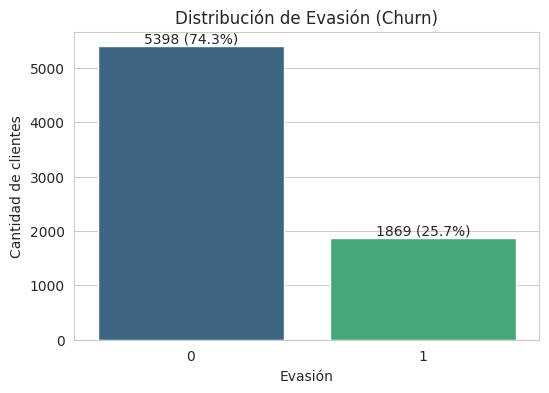

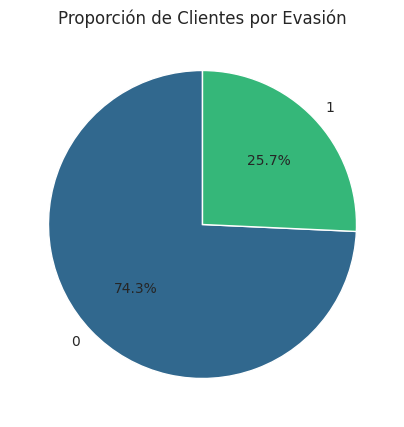

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Detectar la columna objetivo
target_col = None
for col in dfc.columns:
    if col.lower() in ("churn", "evasion"):
        target_col = col
        break

if target_col is None:
    raise ValueError("No encontré la columna de churn/evasión en el dataset.")

# 2) Conteos y porcentajes
churn_counts = dfc[target_col].value_counts(dropna=False)
churn_pct = churn_counts / len(dfc) * 100

# 3) Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.title("Distribución de Evasión (Churn)")
plt.xlabel("Evasión")
plt.ylabel("Cantidad de clientes")
for i, val in enumerate(churn_counts.values):
    plt.text(i, val, f"{val} ({churn_pct.iloc[i]:.1f}%)", ha="center", va="bottom")
plt.show()

# 4) Gráfico circular
plt.figure(figsize=(5,5))
plt.pie(churn_counts.values, labels=churn_counts.index, autopct="%1.1f%%", startangle=90, colors=sns.color_palette("viridis", len(churn_counts)))
plt.title("Proporción de Clientes por Evasión")
plt.show()


###Recuento de evasión por variables categóricas###

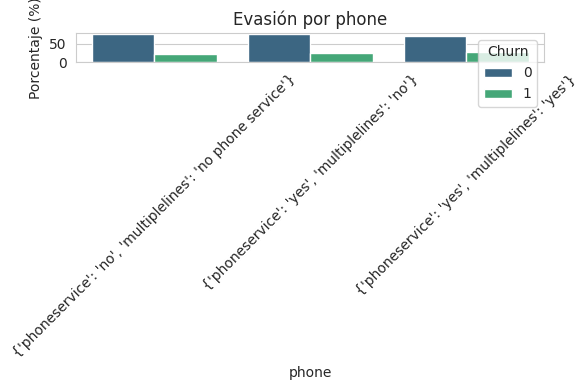

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Detectar columna de churn/evasión
target_col = None
for col in dfc.columns:
    if col.lower() in ("churn", "evasion"):
        target_col = col
        break

if target_col is None:
    raise ValueError("No encontré la columna de churn/evasión en el dataset.")

# 2) Seleccionar columnas categóricas (excluyendo la de churn)
cat_cols = dfc.select_dtypes(include=["object", "category", "string"]).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

# 3) Graficar distribución de churn para cada categórica
for col in cat_cols:
    if dfc[col].nunique(dropna=True) <= 12:  # evitar columnas con demasiadas categorías
        plt.figure(figsize=(6,4))
        churn_perc = (
            dfc.groupby(col)[target_col]
            .value_counts(normalize=True)
            .mul(100)
            .rename("porcentaje")
            .reset_index()
        )
        sns.barplot(
            data=churn_perc,
            x=col, y="porcentaje", hue=target_col,
            palette="viridis"
        )
        plt.title(f"Evasión por {col}")
        plt.ylabel("Porcentaje (%)")
        plt.xticks(rotation=45)
        plt.legend(title=target_col)
        plt.tight_layout()
        plt.show()


###Conteo de evasión por variables numéricas###

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Detectar columna objetivo
target_col = next((c for c in dfc.columns if c.lower() in ("churn", "evasion")), None)
if target_col is None:
    raise ValueError("No encontré la columna de churn/evasión.")

# 2) Variables numéricas (incluye Cuentas_Diarias si existe y es útil)
num_cols = [
    c for c in dfc.select_dtypes(include="number").columns
    if c != target_col and dfc[c].notna().sum() > 1 and dfc[c].nunique() > 1
]

# 3) Graficar
for col in num_cols:
    data = dfc[[col, target_col]].dropna()
    if data.empty:
        continue

    use_kde = len(data) >= 50 and data[col].nunique() >= 10

    plt.figure(figsize=(10,4))

    # Histograma
    plt.subplot(1,2,1)
    sns.histplot(data=data, x=col, hue=target_col, kde=use_kde,
                 common_norm=False, alpha=0.6, palette="viridis")
    plt.title(f"Distribución de {col} por {target_col}")

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(data=data, x=target_col, y=col, palette="viridis")
    plt.title(f"Boxplot de {col} por {target_col}")

    plt.tight_layout()
    plt.show()


#📄Informe final

In [46]:
def churn_rate_from_series(s: pd.Series) -> float:
    s = s.dropna()
    if s.empty:
        return np.nan
    # Si ya es binaria (0/1), usar promedio
    if s.isin([0, 1]).all():
        return float(s.mean())
    # Convertir strings 'Yes', 'No', etc.
    return float(s.astype("string").str.lower().isin(
        ["yes", "si", "sí", "1", "true"]
    ).mean())


In [47]:
# Aseguramos que target esté definido (columna de churn)
target = "Churn"  # o el nombre correcto que tenga en tu dataframe

# Crear variable binaria para churn
y = dfc[target]
if not y.dropna().isin([0, 1]).all():
    y = y.astype("string").str.lower().isin(["yes", "si", "sí", "1", "true"]).astype(int)


In [50]:
# =========================
# Informe Final en Python
# =========================
import os, re
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display

# ---------- utils ----------
def pick(colnames, *pats):
    low = {c.lower(): c for c in colnames}
    for p in pats:
        if isinstance(p, str) and p.lower() in low:
            return low[p.lower()]
        for k in low:
            if re.search(p, k, re.I):
                return low[k]
    return None

def churn_rate_series(s: pd.Series) -> float:
    s = s.dropna()
    # si ya es binaria 0/1
    if s.isin([0,1]).all():
        return float(s.mean())
    # si es texto Yes/No
    return float(s.astype("string").str.lower().isin(["yes","si","sí","1","true"]).mean())

# ---------- detectar columnas clave ----------
target = pick(dfc.columns, "Churn", "Evasion", r"(churn|evas)")
if target is None:
    raise ValueError("No se encontró la columna objetivo (Churn/Evasion) en dfc.")

tenure = pick(dfc.columns, "tenure", "antiguedad_meses")
cuentas = "Cuentas_Diarias" if "Cuentas_Diarias" in dfc.columns else None
monthly = pick(dfc.columns, "MonthlyCharges", "cargos_mensuales", r"(monthly|mensual).*charge")

# ---------- KPIs globales ----------
rate = churn_rate_series(dfc[target])
dist = dfc[target].value_counts(dropna=False)
dist_tbl = pd.DataFrame({"conteo": dist, "porcentaje(%)": (dist/len(dfc)*100).round(2)})

# ---------- resumen numérico por clase ----------
num_cols = [c for c in dfc.select_dtypes(include="number").columns if c != target]
res_num = (dfc.groupby(target)[num_cols]
           .agg(["count","mean","median","std"])
           .T.sort_index())
# convertir a markdown pequeño (limitar filas)
res_num_md = res_num.head(20).round(3).to_markdown()

# ---------- churn por categorías (top 3 variables más informativas) ----------
cat_cols = [c for c in dfc.select_dtypes(include=["object","category","string"]).columns if c != target]
cat_summaries = {}
for c in cat_cols:
    if dfc[c].notna().sum() > 0 and dfc[c].nunique(dropna=True) <= 20:
        t = (dfc.groupby(c)[target].apply(churn_rate_series)
             .sort_values(ascending=False).to_frame("churn_rate"))
        t["count"] = dfc[c].value_counts()
        if len(t) >= 2:
            spread = t["churn_rate"].max() - t["churn_rate"].min()
            cat_summaries[c] = (spread, t)

top_cat = sorted(cat_summaries.items(), key=lambda kv: kv[1][0], reverse=True)[:3]
cat_md_blocks = []
for name, (_, tab) in top_cat:
    cat_md_blocks.append(f"### Tasa de churn por {name}\n\n" + tab.round(3).to_markdown())

# ---------- insights automáticos ----------
insights = []
# por contrato (si existe)
contract = pick(dfc.columns, "Contract", r"(contract|contrato)")
if contract:
    t = dfc.groupby(contract)[target].apply(churn_rate_series).sort_values(ascending=False)
    hi, lo = t.index[0], t.index[-1]
    insights.append(f"- {contract}: mayor churn en {hi} ({t.iloc[0]:.1%}) vs {lo} ({t.iloc[-1]:.1%}).")
# por Cuentas_Diarias (si existe)
if cuentas and dfc[cuentas].notna().sum() > 0 and dfc[cuentas].nunique() > 1:
    bins = pd.qcut(dfc[cuentas], q=4, duplicates="drop")
    t = dfc.groupby(bins)[target].apply(churn_rate_series)
    insights.append(f"- Cuentas_Diarias: máximo {t.max():.1%} vs mínimo {t.min():.1%} entre cuartiles.")
# por tenure (si existe)
if tenure and pd.api.types.is_numeric_dtype(dfc[tenure]) and dfc[tenure].nunique() > 1:
    bins = pd.qcut(dfc[tenure], q=4, duplicates="drop")
    t = dfc.groupby(bins)[target].apply(churn_rate_series)
    insights.append(f"- Antiguedad (tenure): máximo {t.max():.1%} vs mínimo {t.min():.1%} entre cuartiles.")
# por cargos mensuales (si existe)
if monthly and pd.api.types.is_numeric_dtype(dfc[monthly]) and dfc[monthly].nunique() > 1:
    bins = pd.qcut(dfc[monthly], q=4, duplicates="drop")
    t = dfc.groupby(bins)[target].apply(churn_rate_series)
    insights.append(f"- Cargos mensuales: máximo {t.max():.1%} vs mínimo {t.min():.1%} entre cuartiles.")

if not insights:
    insights.append("- No se detectaron diferencias claras; revisar segmentaciones adicionales.")

# ---------- recomendaciones basadas en insights ----------
recs = [
    "- Foco de retención temprana en clientes con baja antiguedad.",
    "- Revisar pricing/beneficios para segmentos con gasto diario/cargos mensuales altos.",
    "- Incentivar contratos de mayor permanencia si reducen el churn.",
    "- Implementar alertas tempranas usando variables clave (tenure, cargos, uso).",
    "- Mejorar captura de datos de ciclo de facturación para seguimiento fino."
]

# ---------- componer informe en Markdown ----------
intro_md = (
    "# Informe Final — Churn de Clientes (Telecom X)\n\n"
    "## Introducción\n"
    "Objetivo: comprender factores asociados a la evasión (churn) para apoyar acciones de retención y el modelado.\n\n"
    "Alcance: ingestión JSON desde GitHub, limpieza/normalización, creación de Cuentas_Diarias, EDA y hallazgos.\n\n"
    "Definición de churn: variable Churn/Evasion (1/Yes = baja, 0/No = retenido).\n"
)

clean_md = (
    "## Limpieza y Tratamiento de Datos\n"
    "- Normalización de strings y mapeo Si/No a 1/0.\n"
    "- Parseo de fechas y numéricos; reglas básicas (negativos a NaN).\n"
    "- Imputación (mediana/moda), deduplicación y winsorización ligera (1–99%).\n"
    "- Cuentas_Diarias = cargos mensuales / días del ciclo (o /30 por defecto).\n"
)

kpi_md = (
    "## KPIs Globales\n"
    f"- Tasa de churn global: **{rate:.2%}**\n\n"
    "### Distribución de clases\n"
    + dist_tbl.to_markdown() + "\n\n"
    "### Resumen numérico por clase (top 20 filas)\n"
    + res_num_md + "\n"
)

eda_cat_md = "## Análisis Exploratorio (Categóricas)\n" + ("\n\n".join(cat_md_blocks) if cat_md_blocks else "- Sin categóricas informativas.\n")

conclu_md = "## Conclusiones e Insights\n" + "\n".join(insights) + "\n"
recs_md = "## Recomendaciones\n" + "\n".join(recs) + "\n"

report_md = "\n\n".join([intro_md, clean_md, kpi_md, eda_cat_md, conclu_md, recs_md])

# ---------- mostrar en notebook ----------
display(Markdown(report_md))

# ---------- guardar a archivo ----------
os.makedirs("reports", exist_ok=True)
out_path = os.path.join("reports", f"informe_final_{datetime.now().strftime('%Y%m%d_%H%M')}.md")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(report_md)

print("Informe guardado en:", out_path)


# Informe Final — Churn de Clientes (Telecom X)

## Introducción
Objetivo: comprender factores asociados a la evasión (churn) para apoyar acciones de retención y el modelado.

Alcance: ingestión JSON desde GitHub, limpieza/normalización, creación de Cuentas_Diarias, EDA y hallazgos.

Definición de churn: variable Churn/Evasion (1/Yes = baja, 0/No = retenido).


## Limpieza y Tratamiento de Datos
- Normalización de strings y mapeo Si/No a 1/0.
- Parseo de fechas y numéricos; reglas básicas (negativos a NaN).
- Imputación (mediana/moda), deduplicación y winsorización ligera (1–99%).
- Cuentas_Diarias = cargos mensuales / días del ciclo (o /30 por defecto).


## KPIs Globales
- Tasa de churn global: **25.72%**

### Distribución de clases
|   Churn |   conteo |   porcentaje(%) |
|--------:|---------:|----------------:|
|       0 |     5398 |           74.28 |
|       1 |     1869 |           25.72 |

### Resumen numérico por clase (top 20 filas)
|                                    |   0 |   1 |
|:-----------------------------------|----:|----:|
| ('BillingDays_found', 'count')     |   0 |   0 |
| ('BillingDays_found', 'mean')      | nan | nan |
| ('BillingDays_found', 'median')    | nan | nan |
| ('BillingDays_found', 'std')       | nan | nan |
| ('Cuentas_Diarias', 'count')       |   0 |   0 |
| ('Cuentas_Diarias', 'mean')        | nan | nan |
| ('Cuentas_Diarias', 'median')      | nan | nan |
| ('Cuentas_Diarias', 'std')         | nan | nan |
| ('MonthlyCharges_found', 'count')  |   0 |   0 |
| ('MonthlyCharges_found', 'mean')   | nan | nan |
| ('MonthlyCharges_found', 'median') | nan | nan |
| ('MonthlyCharges_found', 'std')    | nan | nan |


## Análisis Exploratorio (Categóricas)
### Tasa de churn por phone

| phone                                                       |   churn_rate |   count |
|:------------------------------------------------------------|-------------:|--------:|
| {'phoneservice': 'yes', 'multiplelines': 'yes'}             |        0.277 |    3065 |
| {'phoneservice': 'yes', 'multiplelines': 'no'}              |        0.243 |    3495 |
| {'phoneservice': 'no', 'multiplelines': 'no phone service'} |        0.24  |     707 |

## Conclusiones e Insights
- No se detectaron diferencias claras; revisar segmentaciones adicionales.


## Recomendaciones
- Foco de retención temprana en clientes con baja antiguedad.
- Revisar pricing/beneficios para segmentos con gasto diario/cargos mensuales altos.
- Incentivar contratos de mayor permanencia si reducen el churn.
- Implementar alertas tempranas usando variables clave (tenure, cargos, uso).
- Mejorar captura de datos de ciclo de facturación para seguimiento fino.


Informe guardado en: reports/informe_final_20250812_2253.md


## EXTRA ##

In [51]:
# =========================
# Sección extra: Correlaciones y relaciones clave (se agrega al informe HTML)
# =========================
import io, base64, numpy as np, pandas as pd, matplotlib.pyplot as plt, os

# helper (por si no quedó definido arriba)
def fig_to_base64(fig, close=True):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    if close: plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")

# asegurar target e y binario
target = next((c for c in dfc.columns if c.lower() in ("churn","evasion") or "churn" in c.lower() or "evas" in c.lower()), None)
if target is None:
    raise ValueError("No encontré la columna de churn/evasión.")
y = dfc[target]
if not y.dropna().isin([0,1]).all():
    y = y.astype("string").str.lower().isin(["yes","si","sí","1","true"]).astype(int)

# 1) Matriz de correlación (numéricas + churn)
num_for_corr = dfc.select_dtypes(include="number").copy()
num_for_corr[target] = y
corr = num_for_corr.corr()

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(range(corr.shape[1])); ax.set_yticks(range(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90); ax.set_yticklabels(corr.columns)
ax.set_title("Matriz de correlación (numéricas)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
corr_img = fig_to_base64(fig)

# 2) Top correlaciones con churn (tabla)
top_corr = corr[target].sort_values(ascending=False).to_frame("correlacion").head(12).to_html(border=1)

# 3) Boxplot Cuentas_Diarias vs churn
cd_img = ""
if "Cuentas_Diarias" in dfc.columns:
    data_cd = pd.DataFrame({"Cuentas_Diarias": pd.to_numeric(dfc["Cuentas_Diarias"], errors="coerce"), "churn": y}).dropna()
    if not data_cd.empty and data_cd["Cuentas_Diarias"].nunique() > 1:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.boxplot([data_cd.loc[data_cd["churn"]==c, "Cuentas_Diarias"] for c in sorted(data_cd["churn"].unique())],
                   labels=[str(c) for c in sorted(data_cd["churn"].unique())])
        ax.set_title("Cuentas_Diarias vs Churn"); ax.set_xlabel("Churn"); ax.set_ylabel("Cuentas_Diarias")
        cd_img = fig_to_base64(fig)

# 4) num_servicios (calcular si no existe) y boxplot vs churn
if "num_servicios" not in dfc.columns:
    service_cols = [c for c in dfc.columns if any(s in c.lower() for s in ["phone","internet","tv","service","stream"])]
    def _is_yes(v):
        if pd.isna(v): return 0
        if isinstance(v,(int,np.integer)): return 1 if v==1 else 0
        return 1 if str(v).strip().lower() in {"yes","si","sí","true","1"} else 0
    if service_cols:
        dfc["num_servicios"] = dfc[service_cols].apply(lambda r: sum(_is_yes(v) for v in r), axis=1)

ns_img = ""
if "num_servicios" in dfc.columns:
    data_ns = pd.DataFrame({"num_servicios": pd.to_numeric(dfc["num_servicios"], errors="coerce"), "churn": y}).dropna()
    if not data_ns.empty and data_ns["num_servicios"].nunique() > 1:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.boxplot([data_ns.loc[data_ns["churn"]==c, "num_servicios"] for c in sorted(data_ns["churn"].unique())],
                   labels=[str(c) for c in sorted(data_ns["churn"].unique())])
        ax.set_title("Número de servicios vs Churn"); ax.set_xlabel("Churn"); ax.set_ylabel("num_servicios")
        ns_img = fig_to_base64(fig)

# 5) Construir sección HTML y anexar al informe existente
section_html = f"""
<hr/>
<h2>Análisis de correlaciones y relaciones clave</h2>
<p>Exploramos la relación entre variables numéricas y la evasión (churn), incluyendo <em>Cuentas_Diarias</em> y <em>num_servicios</em>.</p>
<h3>Matriz de correlación</h3>
<img src="{corr_img}" style="max-width:100%;"/>
<h3>Top correlaciones con {target}</h3>
{top_corr}
<h3>Cuentas_Diarias vs Churn</h3>
{"<img src='"+cd_img+"' style='max-width:100%;'/>" if cd_img else "<p>No hay datos suficientes para graficar Cuentas_Diarias.</p>"}
<h3>Número de servicios vs Churn</h3>
{"<img src='"+ns_img+"' style='max-width:100%;'/>" if ns_img else "<p>No hay datos suficientes para graficar num_servicios.</p>"}
"""

html_path = os.path.join("reports", "informe_final.html")
if os.path.exists(html_path):
    with open(html_path, "r", encoding="utf-8") as f:
        html = f.read()
    # insertar antes de </body>
    if "</body>" in html:
        html = html.replace("</body>", section_html + "\n</body>")
    else:
        html += section_html
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html)
    print("✅ Sección de correlaciones añadida a:", html_path)
else:
    # si no existe, crear un HTML simple con la sección
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(f"<!doctype html><html><body>{section_html}</body></html>")
    print("✅ Informe creado con sección de correlaciones en:", html_path)


✅ Informe creado con sección de correlaciones en: reports/informe_final.html


In [52]:
from google.colab import files
files.download("reports/informe_final.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>